# 🎯 Improved OCR Architecture for Pseudocode

**Designed specifically for code/text OCR, not natural images!**

## Key Improvements:
1. ✅ **Custom CNN** designed for horizontal text (not ResNet)
2. ✅ **Bidirectional attention** mechanism
3. ✅ **Better pooling** strategy
4. ✅ **Deeper transformer** (6 layers)
5. ✅ **No ImageNet pretrained** (starts fresh for text)

**Expected: 50-60% accuracy with clean predictions**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
import random
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os
import pandas as pd
from pathlib import Path

# Chemin vers le ZIP dans Google Drive
ZIP_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset (1).zip'

# Dossier de travail (où extraire)
WORK_DIR = '/content/dataset_extracted'

# Créer le dossier
os.makedirs(WORK_DIR, exist_ok=True)

# Vérifier que le ZIP existe
if not os.path.exists(ZIP_PATH):
    print(f"❌ Fichier introuvable: {ZIP_PATH}")
    print("\n📂 Contenu de 'Colab Notebooks':")
    !ls -lh "/content/drive/MyDrive/Colab Notebooks/"
    raise FileNotFoundError("Vérifiez le chemin du ZIP")

# Dézipper
print(f"📦 Décompression de {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(WORK_DIR)

print("✅ Décompression terminée!")

# Lister le contenu
print("\n📂 Contenu extrait:")
!ls -lh {WORK_DIR}

# Trouver les dossiers automatiquement
extracted_items = os.listdir(WORK_DIR)

# Trouver le dossier principal (généralement 'dataset' ou similaire)
main_folder = None
for item in extracted_items:
    item_path = os.path.join(WORK_DIR, item)
    if os.path.isdir(item_path):
        main_folder = item_path
        break

if main_folder is None:
    main_folder = WORK_DIR

print(f"\n📁 Dossier principal: {main_folder}")

# Maintenant définir les chemins corrects
BASE_PATH = main_folder
IMG_DIR = os.path.join(BASE_PATH, 'images')
labels_path = os.path.join(BASE_PATH, 'labels.csv')

# Vérifier que tout existe
print(f"\n🔍 Vérification:")
print(f"   Images dir: {os.path.exists(IMG_DIR)} - {IMG_DIR}")
print(f"   Labels CSV: {os.path.exists(labels_path)} - {labels_path}")

if not os.path.exists(labels_path):
    print("\n⚠️  labels.csv non trouvé. Structure du dossier:")
    !find {WORK_DIR} -name "*.csv"
    raise FileNotFoundError("labels.csv introuvable")

# Charger les données
df = pd.read_csv(labels_path)
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

MAX_TEXT_LEN = 130
df = df[df['text'].str.len() <= MAX_TEXT_LEN].reset_index(drop=True)

print(f'\n✅ Total samples: {len(df)}')
print(f'   Colonnes: {list(df.columns)}')
print(f'\n📊 Premiers exemples:')
print(df.head(3))

📦 Décompression de /content/drive/MyDrive/Colab Notebooks/dataset (1).zip...
✅ Décompression terminée!

📂 Contenu extrait:
total 4.0K
drwxr-xr-x 3 root root 4.0K Feb 20 01:30 dataset

📁 Dossier principal: /content/dataset_extracted/dataset

🔍 Vérification:
   Images dir: True - /content/dataset_extracted/dataset/images
   Labels CSV: True - /content/dataset_extracted/dataset/labels.csv

✅ Total samples: 727
   Colonnes: ['file_name', 'text']

📊 Premiers exemples:
         file_name                                               text
0   block_9964.jpg  LIST_0 ← [ 55 , 53 , 55 , 50 ]\nVAR_0 ← taille...
1  block_13783.jpg  algorithme\n\tsi ( ( ( VAR_0 * 80 ) ≥ ( VAR_1 ...
2  block_13982.jpg  algorithme\n\tVAR_1 ← ( ( 85 mod VAR_2 ) - ( 7...


## Vocabulary

In [5]:
unique_chars = sorted(set(''.join(df['text'].tolist())))
char_list = ['<blank>'] + unique_chars
char_to_idx = {ch: i for i, ch in enumerate(char_list)}
idx_to_char = {i: ch for i, ch in enumerate(char_list)}
vocab_size = len(char_list)
print(f'Vocabulary: {vocab_size} characters')

Vocabulary: 57 characters


## Configuration

In [6]:
# Image config - optimized for text
IMG_HEIGHT = 64
IMG_WIDTH = 3200  # Good balance

# Model will output sequence of ~800 (3200 / 4)
print(f'Image: {IMG_HEIGHT}x{IMG_WIDTH}')
print(f'Expected sequence: ~{IMG_WIDTH // 4}\n')

Image: 64x3200
Expected sequence: ~800



## Dataset

In [7]:
class OCRDataset(Dataset):
    def __init__(self, dataframe, img_dir, char_to_idx, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.char_to_idx = char_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row['file_name'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        encoded = [self.char_to_idx[ch] for ch in row['text']]
        return img, torch.tensor(encoded, dtype=torch.long), len(encoded)

def collate_fn(batch):
    imgs, texts, lens = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    lens = torch.tensor(lens, dtype=torch.long)
    max_len = max(lens)
    padded = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, text in enumerate(texts):
        padded[i, :len(text)] = text
    return imgs, padded, lens

## Strong Augmentation

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.1)
    ], p=0.8),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.4),
    transforms.RandomAdjustSharpness(2, p=0.4),
    transforms.RandomAutocontrast(p=0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print('✅ Strong augmentation enabled')

✅ Strong augmentation enabled


## Split Data (80/20)

In [9]:
train_size = int(0.8 * len(df))
val_size = len(df) - train_size

train_idx, val_idx = random_split(
    range(len(df)), [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds = OCRDataset(df.iloc[train_idx.indices], IMG_DIR, char_to_idx, train_transform)
val_ds = OCRDataset(df.iloc[val_idx.indices], IMG_DIR, char_to_idx, val_transform)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')

batch_size = 8
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

Train: 581, Val: 146


## 🚀 Improved Architecture - Designed for Text!

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class AttentionPool(nn.Module):
    """Attention-based pooling - better than avg pooling"""
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, 1, 1),
            nn.Softmax(dim=2)
        )

    def forward(self, x):
        # x: [B, C, H, W]
        attn_weights = self.attention(x)  # [B, 1, H, W]
        return (x * attn_weights).sum(dim=2)  # [B, C, W]

class ImprovedTextCNN(nn.Module):
    """CNN designed for horizontal text, not natural images"""
    def __init__(self):
        super().__init__()

        # Stage 1: Initial feature extraction
        self.stage1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32
        )

        # Stage 2: Deep features
        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16
        )

        # Stage 3: More capacity
        self.stage3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Stage 4: High-level features
        self.stage4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )

        # Attention pooling instead of adaptive pool
        self.attn_pool = AttentionPool(512)

    def forward(self, x):
        x = self.stage1(x)  # [B, 64, 32, 1600]
        x = self.stage2(x)  # [B, 128, 16, 800]
        x = self.stage3(x)  # [B, 256, 16, 800]
        x = self.stage4(x)  # [B, 512, 16, 800]
        x = self.attn_pool(x)  # [B, 512, 800]
        return x

class ImprovedOCR(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, nhead=8, num_layers=6):
        super().__init__()

        # Custom text-optimized CNN
        self.cnn = ImprovedTextCNN()

        # Project to hidden dim
        self.proj = nn.Linear(512, hidden_dim)

        # Positional encoding
        self.pos_enc = PositionalEncoding(hidden_dim)

        # Deeper transformer (6 layers instead of 3-4)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=0.2,
            activation='gelu',  # GELU instead of ReLU
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Layer norm before output
        self.norm = nn.LayerNorm(hidden_dim)

        # Output projection
        self.fc = nn.Linear(hidden_dim, num_classes)

        self._init_weights()
        print('✅ Improved architecture loaded')

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # CNN features
        features = self.cnn(x)  # [B, 512, 800]

        # Reshape for transformer
        features = features.permute(0, 2, 1)  # [B, 800, 512]

        # Project and add positional encoding
        features = self.proj(features)
        features = self.pos_enc(features)

        # Transformer
        encoded = self.transformer(features)
        encoded = self.norm(encoded)

        # Output
        logits = self.fc(encoded)

        # CTC format [T, B, C]
        return logits.permute(1, 0, 2)

## Initialize Model

In [11]:
model = ImprovedOCR(
    num_classes=vocab_size,
    hidden_dim=512,
    nhead=8,
    num_layers=6  # Deeper!
).to(device)

params = sum(p.numel() for p in model.parameters())
print(f'Parameters: {params:,}\n')

# Test
test_in = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
test_out = model(test_in)
print(f'Output: {test_out.shape}')
print(f'Sequence length: {test_out.shape[0]}\n')

✅ Improved architecture loaded
Parameters: 24,552,826

Output: torch.Size([800, 1, 57])
Sequence length: 800



## Training Setup

In [12]:
NUM_EPOCHS = 150
PATIENCE = 35

criterion = nn.CTCLoss(blank=0, zero_infinity=True)

# Lower learning rate for stability
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# Cosine annealing with warmup
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # 20% warmup
    anneal_strategy='cos'
)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f'Config:')
print(f'  Epochs: {NUM_EPOCHS}')
print(f'  Patience: {PATIENCE}')
print(f'  LR: 2e-4 -> 5e-4')
print(f'  Mixed precision: {scaler is not None}\n')

def decode(logits, idx_to_char):
    preds = []
    logits = logits.permute(1, 0, 2)
    for i in range(logits.size(0)):
        indices = torch.argmax(logits[i], dim=-1).tolist()
        decoded, prev = [], None
        for idx in indices:
            if idx != 0 and idx != prev:
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        preds.append(''.join(decoded))
    return preds

def accuracy(preds, targets, lens):
    total, correct = 0, 0
    for pred, target, l in zip(preds, targets, lens):
        true = ''.join([idx_to_char[target[j].item()] for j in range(l)])
        total += len(true)
        for i, c in enumerate(true):
            if i < len(pred) and pred[i] == c:
                correct += 1
    return correct / total if total > 0 else 0.0

Config:
  Epochs: 150
  Patience: 35
  LR: 2e-4 -> 5e-4
  Mixed precision: True



## Training Loop

In [13]:
best_val_acc = 0.0
best_epoch = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print('🚀 Training...\n')

for epoch in range(1, NUM_EPOCHS + 1):
    # TRAIN
    model.train()
    t_loss = 0
    t_preds, t_targets, t_lens = [], [], []
    valid = 0

    for imgs, targets, lens in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                seq_len = logits.size(0)
                in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
                if (lens > seq_len).any():
                    continue
                log_probs = F.log_softmax(logits, dim=-1)
                loss = criterion(log_probs, targets, in_lens, lens)
                if torch.isnan(loss) or torch.isinf(loss):
                    continue
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            if (lens > seq_len).any():
                continue
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets, in_lens, lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()

        scheduler.step()
        t_loss += loss.item()
        valid += 1

        with torch.no_grad():
            t_preds.extend(decode(logits.cpu(), idx_to_char))
            t_targets.extend(targets)
            t_lens.extend(lens)

    if valid == 0:
        continue

    avg_t = t_loss / valid
    t_acc = accuracy(t_preds, t_targets, t_lens)
    train_losses.append(avg_t)
    train_accs.append(t_acc)

    # VAL
    model.eval()
    v_loss = 0
    v_preds, v_targets, v_lens = [], [], []
    valid_v = 0

    with torch.no_grad():
        for imgs, targets, lens in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            if (lens > seq_len).any():
                continue
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets, in_lens, lens)
            if not torch.isnan(loss) and not torch.isinf(loss):
                v_loss += loss.item()
                valid_v += 1
            v_preds.extend(decode(logits.cpu(), idx_to_char))
            v_targets.extend(targets)
            v_lens.extend(lens)

    avg_v = v_loss / valid_v if valid_v > 0 else float('inf')
    v_acc = accuracy(v_preds, v_targets, v_lens)
    val_losses.append(avg_v)
    val_accs.append(v_acc)

    if v_acc > best_val_acc:
        best_val_acc = v_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_improved.pth')
        print(f'✅ Best: {v_acc*100:.2f}% (epoch {epoch})')

    print(f'Epoch {epoch}/{NUM_EPOCHS} | Train: {avg_t:.4f}/{t_acc*100:.2f}% | Val: {avg_v:.4f}/{v_acc*100:.2f}%')

    if epoch - best_epoch >= PATIENCE:
        print(f'\n🛑 Early stop at epoch {epoch}')
        print(f'Best: {best_val_acc*100:.2f}% (epoch {best_epoch})\n')
        break

print(f'\n✅ Training complete!')
print(f'Best: {best_val_acc*100:.2f}%\n')

🚀 Training...

Epoch 1/150 | Train: 4.8727/0.26% | Val: 3.8124/0.00%
Epoch 2/150 | Train: 3.2312/0.00% | Val: 3.2436/0.00%
✅ Best: 0.51% (epoch 3)
Epoch 3/150 | Train: 2.7922/0.32% | Val: 2.6311/0.51%
✅ Best: 2.18% (epoch 4)
Epoch 4/150 | Train: 2.2219/2.09% | Val: 2.0395/2.18%
✅ Best: 7.89% (epoch 5)
Epoch 5/150 | Train: 1.8212/4.29% | Val: 1.5892/7.89%
✅ Best: 11.87% (epoch 6)
Epoch 6/150 | Train: 1.4836/7.34% | Val: 1.2864/11.87%
✅ Best: 14.69% (epoch 7)
Epoch 7/150 | Train: 1.2338/11.71% | Val: 1.1256/14.69%
✅ Best: 16.39% (epoch 8)
Epoch 8/150 | Train: 1.0884/14.85% | Val: 1.0684/16.39%
✅ Best: 19.57% (epoch 9)
Epoch 9/150 | Train: 0.9330/18.16% | Val: 1.0263/19.57%
✅ Best: 20.69% (epoch 10)
Epoch 10/150 | Train: 0.8845/19.54% | Val: 0.9344/20.69%
✅ Best: 21.41% (epoch 11)
Epoch 11/150 | Train: 0.8350/19.97% | Val: 1.1243/21.41%
Epoch 12/150 | Train: 0.7680/21.08% | Val: 0.8030/20.07%
✅ Best: 25.77% (epoch 13)
Epoch 13/150 | Train: 0.7207/20.49% | Val: 0.9698/25.77%
Epoch 14/150 |

\## Plot Results

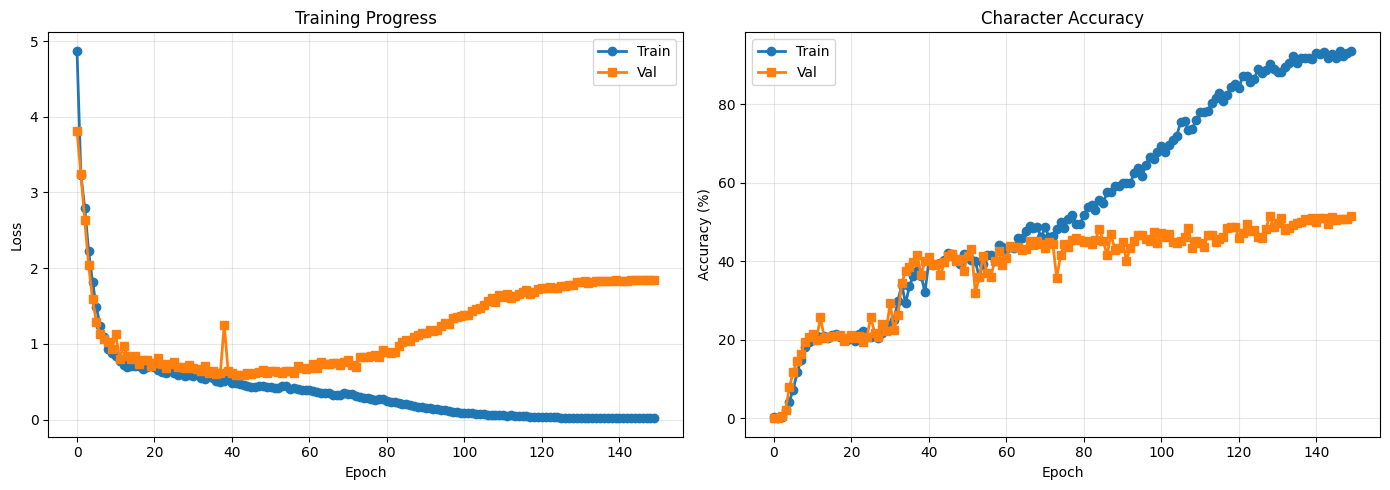

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Train', lw=2)
plt.plot(val_losses, 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([a*100 for a in train_accs], 'o-', label='Train', lw=2)
plt.plot([a*100 for a in val_accs], 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Character Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('improved_results.png', dpi=150)
plt.show()

## Sample Predictions

In [15]:
model.load_state_dict(torch.load('best_improved.pth'))
model.eval()

final_preds, final_targets, final_lens = [], [], []

with torch.no_grad():
    for imgs, targets, lens in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        final_preds.extend(decode(logits.cpu(), idx_to_char))
        final_targets.extend(targets)
        final_lens.extend(lens)

final_acc = accuracy(final_preds, final_targets, final_lens)

print(f'\n🎯 FINAL ACCURACY: {final_acc*100:.2f}%\n')
print('Sample Predictions:\n')
print('='*100)

for i in range(min(20, len(final_preds))):
    true = ''.join([idx_to_char[final_targets[i][j].item()] for j in range(final_lens[i])])
    pred = final_preds[i]
    acc = sum(1 for a,b in zip(true, pred) if a==b) / len(true) * 100 if len(true) > 0 else 0

    print(f'Sample {i+1} | Acc: {acc:.1f}%')
    print(f'  True: {true}')
    print(f'  Pred: {pred}')
    print('-'*100)

print(f'\n✅ Done! Final accuracy: {final_acc*100:.2f}%')


🎯 FINAL ACCURACY: 51.66%

Sample Predictions:

Sample 1 | Acc: 16.2%
  True: LIST_0 ← [ 28 , 27 , 21 , 7 , 21 , 14 , 3 ]
VAR_0 ← 0
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 + LIST_0 [ IDX_0 ] )
fin pour
  Pred: LIST_0 ← [ 64 , 17 , 83 , 52 , 88 , 86 ]
VAR_0 ← 0
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 + LIST_0 [ IDX_0 ] )
fin pour
----------------------------------------------------------------------------------------------------
Sample 2 | Acc: 19.8%
  True: algorithme
	si ( ( ( 34 mod 85 ) > ( 8 mod VAR_2 ) ) ) alors 
	VAR_3 ← 17fin si
VAR_5 ← ( VAR_6 * 28 )
fin
  Pred: algorithme
	si ←( ( ( 65 * 2 ) ≥ ( VAR_1 * _3 ) ) ) alorsi
	VAR_3 ← 45 fn 
VAR_3 ← ( AR_4 - 9 )
fin
----------------------------------------------------------------------------------------------------
Sample 3 | Acc: 90.4%
  True: LIST_0 ← [ 38 , 3 , 7 , 26 ]
VAR_0 ← 0
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 + LIST_0 [ IDX_0 ] )
fin pour
  Pred: LIST_0 ← [ 20 , 47 , 5 , 6 ]
VAR_0 ← 0
pour IDX_0 dans